# Spam Classification
Authors: [RedSkittleFox](https://github.com/RedSkittleFox), [DJAltair](https://github.com/DJAltair)

# Get the Data

In [1]:
import os
import pandas as pd
import numpy as np 

spam_classification : pd.DataFrame = pd.read_csv(os.path.join("data", "spam_classification.csv"), sep=";")
spam_classification.head()

,Money,Free,Rich,Inappropriate,Classified,Spam
0,no,no,yes,no,yes,yes
1,yes,yes,yes,no,no,yes
2,no,no,no,no,no,no
3,no,yes,no,no,no,yes
4,yes,no,no,no,no,no


# Naive Bayes Classifier
Naive Bayes Classifier is a simplification of the more accurate Bayes Classifier. It assumes that all the attributes in the dataset are independent of each other. That assumption allows us to make the following simplification:
$$
Pr(X | C_i) = Pr(x_1, \dots, x_k, \dots, x_n | C_i) = \prod_{k = 1}^n Pr(x_k | C_i)
$$
The goal is to solve the following equation
$$
C^* = \arg \max_{C_i : i \geq 1} (Pr(X|C_i) \cdot Pr(C_i)) = \arg \max_{C_i : i \geq 1} (Pr(C_i) \prod_{k = 1}^n Pr(x_k | C_i))
$$
In the next step we estimate $Pr(C_i)$ and $Pr(x_k | C_i)$ 
$$
Pr(C_i) = \frac{|C_i|}{|Z|}
$$
$$
Pr(x_k | C_i) = \frac{|C_i^{x_k}|}{|C_i|}
$$
Some situations will yield the null probability and thus we need to use the Laplace's smoothing to account for that.
$$
Pr(C_i) = \frac{|C_i| + \lambda }{|Z| + \lambda \cdot m} \quad i = 1, \dots, m
$$
$$
Pr(x_k | C_i) = \frac{|C_i^{x_k}| + \lambda}{|C_i| + \lambda \cdot |x_k|} \quad i = 1, \dots, n
$$

## Implementation

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder

class NaiveBayessClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, laplace_smoothing = False, verbose = True):
        self.laplace_smoothing = laplace_smoothing
        self.verbose = verbose
    def fit(self, X, y):
        ohe = OneHotEncoder()
        ohe.fit(X)
        self.x_categories_ = ohe.categories_.copy()
        
        ohe = OneHotEncoder()
        ohe.fit(pd.DataFrame(y))
        self.y_categories = ohe.categories_[0].copy()

        og_columns = X.columns.copy()

        self.prob_data = {}
        self.prob_y = {}

        for p in self.y_categories:
            count = len(y)
            cat_count = 0
            for row in y.to_numpy():
                if(row == p):
                    cat_count = cat_count + 1    

            prob = 0.0
            if self.laplace_smoothing == False:
                prob = float(cat_count) / float(count)
            else:
                m = len(self.y_categories) 
                prob = (float(cat_count) + 1.0) / (float(count) + m)

            self.prob_y[f"{p}"] = prob

            self.prob_data[f"{p}"] = {}
            for c in og_columns:
                for cat in self.x_categories_[X.columns.get_loc(c)]:
                    count = 0
                    cat_count = 0
                    for index, row in X.iterrows():
                        if(y.to_numpy()[int(index)] != p):
                            continue
                        count = count + 1
                        if(row[c] == cat):
                            cat_count += 1

                    prob = 0.0
                    if self.laplace_smoothing == False:
                        prob = float(cat_count) / float(count)
                    else:
                        m = len(self.x_categories_[X.columns.get_loc(c)])
                        prob = (float(cat_count) + 1) / (float(count) + m)

                    self.prob_data[f"{p}"][f"{c}={cat}"] = prob

                    None

        if self.verbose:
            print(self.prob_data)

        return self

    def predict(self, X):
        results = np.array([*range(0, len(X))], dtype=object)
        for i, row in X.iterrows():
            v = {}
            for y_cat in self.y_categories:
                v[y_cat] = self.prob_y[f"{y_cat}"] 
                out = f"{y_cat} : ({y_cat}){v[y_cat]} * "
                for x_label in X.columns:
                    d = self.prob_data[f'{y_cat}']
                    f = self.prob_data[f"{y_cat}"][f"{x_label}={row[x_label]}"]
                    v[y_cat] = v[y_cat] * f
                    out = out + f" {x_label}({f}) *"
            
                out = out[:-1]
                out = out + f"= {v[y_cat]}"
                if self.verbose:
                    print(out)
            

            m = max(v, key=v.get)
            results[i] = m
            
            if self.verbose:
                print(f"max(p) = {m}")

        return results

## Training

In [3]:
classifier = NaiveBayessClassifier(laplace_smoothing=True)
X = spam_classification[["Money", "Free", "Rich", "Inappropriate", "Classified"]]
Y = spam_classification["Spam"]
classifier.fit(X, Y)

pred_x = pd.DataFrame({
    "Money" : [ "no" ],
    "Free" : [ "no" ],
    "Rich" : [ "no" ],
    "Inappropriate" : [ "yes" ],
    "Classified" : [ "yes" ]
})
results = classifier.predict(pred_x)

print(results)

{'no': {'Money=no': 0.7142857142857143, 'Money=yes': 0.2857142857142857, 'Free=no': 0.5714285714285714, 'Free=yes': 0.42857142857142855, 'Rich=no': 0.7142857142857143, 'Rich=yes': 0.2857142857142857, 'Inappropriate=no': 0.8571428571428571, 'Inappropriate=yes': 0.14285714285714285, 'Classified=no': 0.7142857142857143, 'Classified=yes': 0.2857142857142857}, 'yes': {'Money=no': 0.6, 'Money=yes': 0.4, 'Free=no': 0.4, 'Free=yes': 0.6, 'Rich=no': 0.6, 'Rich=yes': 0.4, 'Inappropriate=no': 0.6, 'Inappropriate=yes': 0.4, 'Classified=no': 0.5, 'Classified=yes': 0.5}}
no : (no)0.4 *  Money(0.7142857142857143) * Free(0.5714285714285714) * Rich(0.7142857142857143) * Inappropriate(0.14285714285714285) * Classified(0.2857142857142857) = 0.004759921461295888
yes : (yes)0.6 *  Money(0.6) * Free(0.4) * Rich(0.6) * Inappropriate(0.4) * Classified(0.5) = 0.01728
max(p) = yes
['yes']


| | Money | Free | Rich | Inappropriate | Classified | $Pr(C_i)$ |
|---|---|---|---|---|---|---|
|Yes|0.6|0.4|0.6|0.4|0.5|0.6|
|No|0.71429|0.57143|0.71429|0.14286|0.28571|0.4|

## Predictions

Bayessian score : 0.8461538461538461


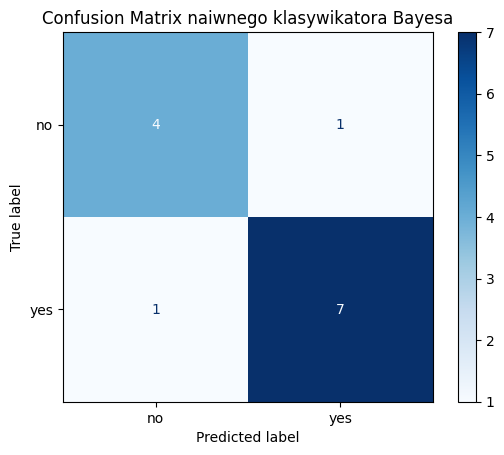

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kNN = NaiveBayessClassifier(laplace_smoothing=True, verbose = False)
kNN.fit(X, Y)

Y_pred = kNN.predict(X)
score = accuracy_score(Y, Y_pred)

print(f"Bayessian score : {score}")
mat = confusion_matrix(Y, Y_pred)
disp = ConfusionMatrixDisplay.from_predictions(
    y_true = Y, 
    y_pred = Y_pred,
    cmap=plt.cm.Blues,
    labels=kNN.y_categories
    )

disp.ax_.set_title(f"Confusion Matrix naiwnego klasywikatora Bayesa")

plt.show()